In [1003]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.ops import nearest_points
from shapely.ops import linemerge
from shapely.geometry import LineString
from shapely.geometry import Point
import networkx as nx
import osmnx as ox
from shapely.geometry import shape, LineString, MultiLineString
from shapely.wkt import loads as wkt_loads
from shapely.ops import transform
from pyproj import Transformer
from scipy.spatial import KDTree
import re
from pulp import LpProblem, LpMinimize, LpVariable, lpSum
from scipy.optimize import linprog
from datetime import datetime, timedelta



In [ ]:
from shapely.ops import nearest_points

def find_nearest_node(point, graph):
    """
    找到离 point 最近的 graph 节点
    """
    min_dist = float('inf')
    nearest_node = None

    for node, data in graph.nodes(data=True):
        node_geom = data['geometry']
        dist = point.distance(node_geom)
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    return nearest_node


Construct Rail Graph

In [673]:
rail=gpd.read_file('/Volumes/Xi兔/optimization/transit/CTA_RailLines/CTA_RailLines.shp')
railstop=gpd.read_file('/Volumes/Xi兔/optimization/transit/CTA_RailStations/CTA_RailStations.shp')
rail = rail.to_crs("EPSG:4326")  # 转换为 WGS84 坐标系
railstop = railstop.to_crs("EPSG:4326")
railstop['LINES'] = railstop['LINES'].str.split(',')
rail['LINES'] = rail['LINES'].str.split(',')
for id,row in rail.iterrows():
    lines=row['LINES']
    updated_lines = []
    for line in lines:
        updated_line = line.split(" Line")[0]
        updated_line = re.sub(r"\s*\(.*?\)", "", updated_line).strip()
        updated_lines.append(updated_line)
    rail.at[id, 'LINES'] = updated_lines
rail_expanded=rail.explode('LINES')
rail_expanded=rail_expanded.reset_index(drop=True)
for id,row in railstop.iterrows():
    lines=row['LINES']
    updated_lines = []
    for line in lines:
        if '&' in line:
            new_lines = []
            # 用 & 拆分 line
            parts = line.split('&')
            # 去除每部分的多余空格
            parts = [part.strip() for part in parts]
            # 将拆分后的部分加入新列表
            new_lines.extend(parts)
            line=new_lines
            for l in line:
                updated_line = l.split(" Line")[0]
                updated_line = re.sub(r"\s*\(.*?\)", "", updated_line).strip()
                updated_lines.append(updated_line)
            continue
        updated_line = line.split(" Line")[0]
        updated_line = re.sub(r"\s*\(.*?\)", "", updated_line).strip()
        updated_lines.append(updated_line)
    railstop.at[id, 'LINES'] = updated_lines
railstop_stops_expanded=railstop.explode('LINES')
railstop_stops_expanded=railstop_stops_expanded.reset_index(drop=True)
G_rail = nx.MultiDiGraph()
G_rail.graph['crs'] = "EPSG:4326"
for color in ['Brown', 'Orange', 'Pink', 'Purple', 'Yellow', 'Green', 'Red',
       'Blue']:
   stops=railstop_stops_expanded[railstop_stops_expanded['LINES']==color]
   routes=rail_expanded[rail_expanded['LINES']==color]
   all_points = set()

   # 遍历 routes 中的 geometry 列
   for geom in routes['geometry']:
      if isinstance(geom, LineString):  # 确保是 LineString 类型
        points = list(geom.coords)  # 提取所有坐标点
        all_points.update(points)  # 加入集合，去重

   # 将集合转换为列表（如果需要）
   coords= list(all_points)
   coords_array = np.array(coords)
   tree = cKDTree(coords_array)

  # 创建 coords -> route_stops 的映射字典
   coords_to_route_stop = {}
   for _, row in stops.iterrows():
     point = row['geometry']  # Shapely Point
     systemstop = row['STATION_ID']
     dist, idx = tree.query([point.x, point.y])
     nearest_coord = tuple(coords_array[idx])
     coords_to_route_stop[nearest_coord] = systemstop
   for line in routes['geometry']:
     coords = list(line.coords)  # 提取坐标点
     for i in range(len(coords)):
    
      coord_tuple = tuple(coords[i])
      if coord_tuple in coords_to_route_stop:
        node_id = f"{coords_to_route_stop[coord_tuple]}_{color}"
      else:
        node_id = f"{coords[i][0]},{coords[i][1]}"
      G_rail.add_node(node_id, geometry=Point(coords[i]))

        
        # 添加边
      if i > 0:  # 确保至少有两个点才能构建边
            prev_coord_tuple = tuple(coords[i-1])
            if prev_coord_tuple in coords_to_route_stop:
              prev_node_id = f"{coords_to_route_stop[prev_coord_tuple]}_{color}"
            else:
              prev_node_id = f"{coords[i-1][0]},{coords[i-1][1]}"
            
            edge_geom = LineString([coords[i-1], coords[i]])
            G_rail.add_edge(
                prev_node_id, node_id,
                geometry=edge_geom
            )
# 提取节点
node_data = []
for node, data in G_rail.nodes(data=True):
    if 'geometry' in data:
        node_data.append({
            'osmid': node,
            'x': data['geometry'].x,
            'y': data['geometry'].y,
            'geometry': data['geometry']
        })

rail_nodes_gdf = gpd.GeoDataFrame(node_data, crs="EPSG:4326")

# 提取边
edge_data = []
for u, v, data in G_rail.edges(data=True):
    edge_data.append({
        'from': u,
        'to': v,
        'geometry': data['geometry']
    })

rail_edges_gdf = gpd.GeoDataFrame(edge_data, crs="EPSG:4326")

Construct bus graph

In [678]:

bus=gpd.read_file('/Volumes/Xi兔/optimization/transit/CTA_BusRoutes/CTA_BusRoutes.shp')
bus = bus.to_crs("EPSG:4326")
busstop=gpd.read_file('/Volumes/Xi兔/optimization/transit/CTA_BusStops_20241214.csv')
busstop['geometry'] = busstop['the_geom'].apply(wkt.loads)

# 转换为 GeoDataFrame
busstop = gpd.GeoDataFrame(busstop, geometry='geometry', crs='EPSG:4326')
busstop['ROUTESSTPG'] = busstop['ROUTESSTPG'].str.split(',')
bus_stops_expanded = busstop.explode('ROUTESSTPG')
bus_stops_expanded.rename(columns={'ROUTESSTPG': 'ROUTEID'}, inplace=True)
bus_stops_expanded['ROUTEID'] = bus_stops_expanded['ROUTEID'].str.strip()
merged = bus_stops_expanded.merge(bus[['ROUTE', 'geometry','NAME']], left_on='ROUTEID',right_on='ROUTE',suffixes=('_stop', '_route'),how='inner',indicator=True)
for i, row in merged.iterrows():
    merged.loc[i, 'point_projected'] = row['geometry_route'].interpolate(row['geometry_route'].project(row['geometry_stop']))  # 投影到路线
G_bus = nx.MultiDiGraph()
G_bus.graph['crs'] = "EPSG:4326"

for route_id, group in merged.groupby('ROUTE'):
  route_stops = group[['SYSTEMSTOP', 'point_projected']].drop_duplicates().reset_index(drop=True)
  route_geometry_0 = group['geometry_route'].unique()[0]
  unique_coords = set()
  for line in route_geometry_0.geoms:
    coords = list(line.coords)
    unique_coords.update(coords)  # 使用集合去重
    
  coords = list(unique_coords)  # 转换为列表格式
    
    # 构建 KDTree，用于最近点查找
  coords_array = np.array(coords)
  tree = cKDTree(coords_array)

    # 创建 coords -> route_stops 的映射字典
  coords_to_route_stop = {}
  for _, row in route_stops.iterrows():
    point = row['point_projected']  # Shapely Point
    systemstop = row['SYSTEMSTOP']
        
        # 查找最近点
    dist, idx = tree.query([point.x, point.y])
    nearest_coord = tuple(coords_array[idx])
        
        # 构建映射关系
    coords_to_route_stop[nearest_coord] = systemstop
  for line in route_geometry_0.geoms:
    coords = list(line.coords)  # 提取坐标点
    for i in range(len(coords)):
        # 添加点作为节点，(x, y) 作为唯一标识
      coord_tuple = tuple(coords[i])
            # 如果 coords 在映射字典中，使用 SYSTEMSTOP_route_id 作为节点 ID
      if coord_tuple in coords_to_route_stop:
        node_id = f"{coords_to_route_stop[coord_tuple]}_{route_id}"
      else:
                # 否则使用默认的 x,y 形式
          node_id = f"{coords[i][0]},{coords[i][1]}"
      G_bus.add_node(node_id, geometry=Point(coords[i]))

        
        # 添加边
      if i > 0:  # 确保至少有两个点才能构建边
            prev_coord_tuple = tuple(coords[i-1])
            if prev_coord_tuple in coords_to_route_stop:
              prev_node_id = f"{coords_to_route_stop[prev_coord_tuple]}_{route_id}"
            else:
              prev_node_id = f"{coords[i-1][0]},{coords[i-1][1]}"
            
            edge_geom = LineString([coords[i-1], coords[i]])
            G_bus.add_edge(
                prev_node_id, node_id,
                geometry=edge_geom
            )


node_data = []
for node, data in G_bus.nodes(data=True):
    if 'geometry' in data:
        node_data.append({
            'osmid': node,
            'x': data['geometry'].x,
            'y': data['geometry'].y,
            'geometry': data['geometry']
        })

bus_nodes_gdf = gpd.GeoDataFrame(node_data, crs="EPSG:4326")

# 提取边
edge_data = []
for u, v, data in G_bus.edges(data=True):
    edge_data.append({
        'from': u,
        'to': v,
        'geometry': data['geometry']
    })

bus_edges_gdf = gpd.GeoDataFrame(edge_data, crs="EPSG:4326")
    




Road network graph

In [ ]:
graphml_file = "/Volumes/Xi兔/osmnx/msa_graphml/Chicago-Naperville-Elgin, IL-IN-WI.graphml"  # 替换为你的文件路径
G_road = nx.read_graphml(graphml_file) 
# 找出缺少 'geometry' 属性的边
edges_missing_geometry = [
    (u, v) for u, v, data in G_road.edges(data=True)
    if 'geometry' not in data
]

# 打印结果
if edges_missing_geometry:
    print(f"Found {len(edges_missing_geometry)} edges missing 'geometry' attribute:")
    for u, v in edges_missing_geometry:
        print(f"Edge ({u}, {v}) is missing 'geometry'")
else:
    print("All edges have the 'geometry' attribute.")
edges_to_remove = [
    (u, v, k) for u, v, k, data in G_road.edges(data=True, keys=True)
    if 'geometry' not in data
]
G_road.remove_edges_from(edges_to_remove)
# 找出缺少 'geometry' 属性的边
edges_missing_geometry = [
    (u, v) for u, v, data in G_road.edges(data=True)
    if 'geometry' not in data
]

# 打印结果
if edges_missing_geometry:
    print(f"Found {len(edges_missing_geometry)} edges missing 'geometry' attribute:")
    for u, v in edges_missing_geometry:
        print(f"Edge ({u}, {v}) is missing 'geometry'")
else:
    print("All edges have the 'geometry' attribute.")

Import trip

In [450]:
# 将时间列解析为 datetime 对象
df = pd.read_csv('/Volumes/Xi兔/optimization/Taxi_Trips.csv')
df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'], format="%m/%d/%Y %I:%M:%S %p")
trip = df[df['Trip Start Timestamp'].dt.date == pd.to_datetime("12/01/2023").date()]
trip = trip[trip['Pickup Centroid Location'] != trip['Dropoff Centroid  Location']]
trip.dropna(subset=['Pickup Centroid Location', 'Dropoff Centroid  Location'], inplace=True)
trip.to_csv("/Volumes/Xi兔/optimization/1201trip.csv", index=False)

Setting graph edge attribute

In [513]:
speed_bus = 10
speed_rail = 20
speed_drive = 15
speed_walk = 1.4
def calculate_travel_time(length, speed):
    return length / speed

def project_graph_edges_with_geometry(graph, crs_from="EPSG:4326", crs_to="EPSG:3857"):
    """
    将图中每条边的 geometry 坐标系转换为指定投影坐标系，并计算长度。
    """
    # 初始化坐标转换器
    transformer = Transformer.from_crs(crs_from, crs_to, always_xy=True)

    def project_geometry(geom):
        """将字符串或几何对象转换为 shapely 几何对象并投影"""
        if isinstance(geom, str):
            try:
                if geom.startswith("LINESTRING") or geom.startswith("MULTILINESTRING"):
                    geom = wkt_loads(geom)  # WKT 格式
                else:
                    geom = shape(eval(geom))  # GeoJSON 格式字符串
            except Exception as e:
                raise ValueError(f"Invalid geometry format: {geom}, Error: {e}")
        
        if geom.is_empty:  # 检查几何是否为空
            return geom
        return transform(transformer.transform, geom)

    # 遍历图中的每条边，转换 geometry 并计算长度
    for u, v, data in graph.edges(data=True):
        if 'geometry' in data:  # 确保边具有 geometry 属性
            try:
                projected_geom = project_geometry(data['geometry'])
                data['geometry_proj'] = projected_geom  # 保存转换后的 geometry
                data['length'] = projected_geom.length  # 计算长度，单位是米
            except Exception as e:
                print(f"Error processing edge ({u}, {v}): {e}")
        else:
            print(f"Edge ({u}, {v}) does not have geometry.")

    return graph



# 对所有图进行坐标系转换和边长计算
graph_bus = project_graph_edges_with_geometry(G_bus)
graph_rail = project_graph_edges_with_geometry(G_rail)
road_network_graph = project_graph_edges_with_geometry(G_road)
speed_bus = 10
speed_rail = 20
speed_drive = 15
speed_walk = 1.4

def calculate_travel_time(length, speed):
    try:
        length = float(length)  # 强制将长度转换为 float
        return length / speed
    except ValueError as e:
        raise ValueError(f"Invalid length value: {length}, Error: {e}")

# Step 1: 设置各个图的 edge weight
for u, v, data in graph_bus.edges(data=True):
    data['travel_time'] = calculate_travel_time(data['length'], speed_bus)

for u, v, data in graph_rail.edges(data=True):
    data['travel_time'] = calculate_travel_time(data['length'], speed_rail)

for u, v, data in road_network_graph.edges(data=True):
    # 设置 driving 和 walking 两种 travel_time
    data['travel_time'] = calculate_travel_time(data['length'], speed_drive)

Construct hybrid network

In [ ]:
road_nodes, coordinates = zip(*[(node, (data['x'], data['y'])) for node, data in road_network_graph.nodes(data=True)])
kdtree = KDTree(coordinates)

def find_nearest_node_from_wkt(wkt_point, road_nodes, kdtree):
    """
    将 WKT 点映射到 road network 上的最近节点。
    """
    point = wkt_loads(wkt_point)  # 解析 WKT 点为 shapely Point
    x, y = point.x, point.y
    _, idx = kdtree.query([x, y])  # 查找最近的节点索引
    return road_nodes[idx]

In [542]:
graph_bus = graph_bus.to_undirected()
graph_rail = graph_rail.to_undirected()
road_network_graph = road_network_graph.to_undirected()
road_nodes = np.array([[data['x'], data['y']] for _, data in road_network_graph.nodes(data=True)])
kdtree = KDTree(road_nodes)
stops=merged
for id, group in merged.groupby('SYSTEMSTOP'):
      route_stops = group[['ROUTE', 'point_projected']].drop_duplicates().reset_index(drop=True)
      for index,row in route_stops.iterrows(): 
        stop_point = row['point_projected']
        _, idx = kdtree.query([stop_point.x, stop_point.y])
        nearest_node = list(road_network_graph.nodes())[idx]
        virtual_node = f"{id}_{row['ROUTE']}"  # 虚拟节点名称
        graph_bus.add_edge(nearest_node, virtual_node, travel_time=450)  # 连通边
        #print(f"Added edge between {nearest_node} and {virtual_node}")
        for other_route in route_stops['ROUTE']:
                if row['ROUTE'] != other_route:
                    other_virtual_node = f"{id}_{other_route}"
                    graph_bus.add_edge(virtual_node, other_virtual_node, travel_time=450)
                    #print(f"Added transfer edge between {virtual_node} and {other_virtual_node}")

for id,stop in railstop.iterrows():  # stops 包含站点ID、坐标、和路线信息
        stop_point = stop['geometry']  # 提取站点坐标
        _, idx = kdtree.query([stop_point.x, stop_point.y])
        nearest_node = list(road_network_graph.nodes())[idx]
        for route in stop['LINES']:
            virtual_node = f"{stop['STATION_ID']}_{route}"  # 虚拟节点名称
            graph_rail.add_edge(nearest_node, virtual_node, travel_time=450)  # 连通边
            for other_route in stop['LINES']:
                if route != other_route:
                    other_virtual_node = f"{stop['STATION_ID']}_{other_route}"
                    graph_rail.add_edge(virtual_node, other_virtual_node, travel_time=450)      
def add_mode_attribute(graph, mode_value):
    """
    为图的所有边添加 mode 属性。
    :param graph: NetworkX 图
    :param mode_value: 边的 mode 值 ('bus', 'rail', 'road')
    """
    for u, v, data in graph.edges(data=True):
        data['mode'] = mode_value
    return graph

# 为三张图添加 mode 属性
graph_bus = add_mode_attribute(graph_bus, 'bus')
graph_rail = add_mode_attribute(graph_rail, 'rail')
road_network_graph = add_mode_attribute(road_network_graph, 'road')

# 合并三张图
multimodal_graph = nx.compose_all([graph_bus, graph_rail, road_network_graph])
  

Calculate the shortest path in multimode graph

In [ ]:
stat={}
for idx, row in trip.iterrows():
    pickup = row['Pickup Centroid Location']
    dropoff = row['Dropoff Centroid  Location']
        
        # 映射到最近节点
    origin_node = find_nearest_node_from_wkt(pickup, road_nodes, kdtree)
    destination_node = find_nearest_node_from_wkt(dropoff, road_nodes, kdtree)

    try:
        # 计算最短路径
        shortest_path = nx.shortest_path(multimodal_graph, source=origin_node, target=destination_node, weight='travel time')
        print(f"\nTrip {idx + 1}:")
        print(f"Origin: {origin_node}, Destination: {destination_node}")
        print("Shortest Path:")
        current_mode = None
        start_node = None
        mode_stats = []
        cumulative_time = 0
            # 遍历路径中的边，打印边的类型
        for i in range(len(shortest_path) - 1):
            u, v = shortest_path[i], shortest_path[i + 1]
            edge_data = multimodal_graph.get_edge_data(u, v)
            for key, attributes in edge_data.items():
                mode = attributes.get('mode', 'unknown')
                travel_time = attributes.get('travel_time', 0)
                if current_mode is None:
                    current_mode = mode
                    start_node = u
                if mode != current_mode:
                    mode_stats.append({
                      "start": start_node,
                      "end": u,
                      "mode": current_mode,
                      "travel_time": cumulative_time
            })
                    current_mode = mode
                    start_node = u
                    cumulative_time = 0
                cumulative_time += travel_time
        if current_mode is not None:
            mode_stats.append({
        "start": start_node,
        "end": shortest_path[-1],
        "mode": current_mode,
        "travel_time": cumulative_time
    })    
            # 计算路径的总 travel_time
        total_time = nx.shortest_path_length(multimodal_graph,source=origin_node, target=destination_node, weight='travel_time')
        print(f"Total Travel Time: {total_time:.2f} seconds")
        stat[idx] = mode_stats
        print(mode_stats)
    except nx.NetworkXNoPath:
        print(f"\nTrip {idx + 1}: No path found between {origin_node} and {destination_node}")
for idx, mode_stats in stat.items():
    for stat_entry in mode_stats:
        # 检查 mode 和 travel_time 条件
        if stat_entry['mode'] == 'road' and stat_entry['travel_time'] < 300:
            stat_entry['mode'] = 'walk'
import json
with open('/Volumes/Xi兔/optimization/stat.json', 'w') as f:
    json.dump(stat, f, indent=4)

Serve some shortest travel time between od


In [628]:

import networkx as nx

def preprocess_travel_times(road_graph, demands):
    # 提取所有 pickup 和 dropoff 点
    unique_points = set()
    for demand in demands:
        unique_points.add(demand['pickup'])
        unique_points.add(demand['dropoff'])

    # 计算所有点对的最短路径时间
    travel_time_cache = {}
    for source in unique_points:
        for target in unique_points:
            if source != target:  # 避免自循环
                try:
                    travel_time = nx.shortest_path_length(
                        road_graph, source=source, target=target, weight='travel_time'
                    )
                    travel_time_cache[(source, target)] = travel_time
                    print(f"Calculated travel time from {source} to {target}: {travel_time:.2f} seconds")
                except nx.NetworkXNoPath:
                    travel_time_cache[(source, target)] = float('inf')  # 无路径时标记为无穷大

    return travel_time_cache
data = [
        {"source": source, "target": target, "travel_time": travel_time}
        for (source, target), travel_time in travel_time_cache.items()
    ]
travel_time_df = pd.DataFrame(data)

travel_time_df.to_csv('/Volumes/Xi兔/optimization/travel_time.csv', index=False)

In [1055]:
def get_cached_travel_time(pickup, dropoff):
    # 首先在cache中查找
    if (pickup, dropoff) in travel_time_cache:
        return travel_time_cache[(pickup, dropoff)]
    
    # 如果在cache中找不到，则通过图计算最短路径
    try:
        travel_time = nx.shortest_path_length(
            road_network_graph, source=pickup, target=dropoff, weight='travel_time'
        )
    except nx.NetworkXNoPath:
        # 如果无路径可达，可以考虑返回inf或进行其他处理
        travel_time = float('inf')

    # 更新缓存
    travel_time_cache[(pickup, dropoff)] = travel_time

    return travel_time


Simulation and Optimization

In [1063]:
def optimize_dispatch(remaining_demands,num_vehicles,eligible_vehicles,vehicle_available_time, vehicle_positions,vehicle_status, vehicle_total_travel_time,vehicle_rebalancing_travel_time):
    """
    使用矩阵定义的线性规划解决车辆分配问题。

    Args:
        remaining_demands (list): 活跃的需求列表。
        vehicle_positions (list): 每辆车当前的位置。
        vehicle_status (list): 每辆车的状态（"idle" 或 "busy"）。
        vehicle_available_time (list): 每辆车的可用时间。
        current_time (datetime): 当前时间。
        get_cached_travel_time (function): 获取行驶时间的函数。

    Returns:
        solution (list): 包含分配结果的列表。
    """
    discard_penalty = 2000.0
    num_demands = len(remaining_demands)
    # 构建映射
    eligible_vehicle_to_index = {vehicle_id: idx for idx, vehicle_id in enumerate(eligible_vehicles)}

    print(f"Number of Participating Vehicles: {num_vehicles}")
    #print(f"{eligible_vehicles}")
    cost_matrix = np.full((num_vehicles, num_demands), np.inf)
    demand_travel_times = np.full(num_demands, np.inf)
    for j, demand in enumerate(remaining_demands):
        pickup = demand['pickup']
        dropoff = demand['dropoff']
        for vehicle_id in eligible_vehicles:
            idx = eligible_vehicle_to_index[vehicle_id]  # 使用映射后的索引
            cost_matrix[idx, j] = get_cached_travel_time(vehicle_positions[vehicle_id], pickup)
            #print(f"Cost from {vehicle_positions[vehicle_id]} to {pickup}: {cost_matrix[idx, j]:.2f} seconds")
        
        demand_travel_times[j] = get_cached_travel_time(pickup, dropoff)
    #print(cost_matrix)
    

    # Flatten the cost matrix into a 1D array
    c_x = cost_matrix.flatten()
    c_z = np.ones(num_demands) * discard_penalty
    c = np.concatenate([c_x, c_z])

    # Step 2: Equality constraints (每个需求必须被满足)
    Aeq = np.zeros((num_demands, num_vehicles*num_demands + num_demands))
    beq = np.ones(num_demands)

    for j in range(num_demands):
        # 对第j个需求的 x_ij 变量
        for i in range(num_vehicles):
            Aeq[j, i*num_demands + j] = 1
        # 对第j个需求的 z_j 变量
        Aeq[j, num_vehicles*num_demands + j] = 1

    # Step 3: Inequality constraints (每辆车最多服务一个需求)
    Aineq = np.zeros((num_vehicles, num_vehicles * num_demands + num_demands))
    bineq = np.ones(num_vehicles)

    for i in range(num_vehicles):
        Aineq[i, i * num_demands:(i + 1) * num_demands] = 1  # 行索引为车辆 i 的所有变量

    # Step 4: Bounds for the decision variables
    bounds = [(0, 1) for _ in range(num_vehicles * num_demands + num_demands)]

    # Step 5: Solve the linear programming problem
    result = linprog(c, A_eq=Aeq, b_eq=beq, A_ub=Aineq, b_ub=bineq, bounds=bounds, method='highs')

    solution_vector = result.x
    x_sol = solution_vector[:num_vehicles*num_demands].reshape((num_vehicles, num_demands))
    z_sol = solution_vector[num_vehicles*num_demands:]

    assigned_solutions = []
    discarded_demands = []

    # 根据解确定每个需求的分配情况
    for j, demand in enumerate(remaining_demands):
        if z_sol[j] > 0.5:
            # 需求被舍弃
            discarded_demands.append(demand)
        else:
            # 找出服务该需求的车辆
            i_assigned = np.argmax(x_sol[:, j])
            vehicle_id = eligible_vehicles[i_assigned]
            waiting_time = cost_matrix[i_assigned, j]
            travel_time = demand_travel_times[j]

            assigned_solutions.append({
                'vehicle_id': vehicle_id,
                'demand': demand,
                'waiting_time': waiting_time,
                'travel_time': travel_time
            })

    return assigned_solutions, discarded_demands,vehicle_available_time, vehicle_positions,vehicle_status, vehicle_total_travel_time,vehicle_rebalancing_travel_time


In [1053]:
def direct_assign(vehicle_available_time, vehicle_positions,vehicle_status, active_demands,current_time,vehicle_total_travel_time):
    matched_demands = []  # 存储已直接匹配的需求
    remaining_demands = []  # 存储未直接匹配的需求

    for demand in active_demands:
        pickup = demand['pickup']
        assigned = False

        for vehicle_id, position in enumerate(vehicle_positions):
            if position == pickup and vehicle_status[vehicle_id] == "idle" and vehicle_available_time[vehicle_id] <= current_time:
                # 直接分配车辆
                travel_time = get_cached_travel_time(pickup, demand['dropoff'])
                vehicle_positions[vehicle_id] = demand['dropoff']  # 更新车辆位置
                vehicle_status[vehicle_id] = "busy"  # 标记车辆为忙碌
                vehicle_available_time[vehicle_id] = current_time + timedelta(seconds=travel_time)  # 更新车辆可用时间

                # 更新需求状态
                demand['waiting_time'] = 0  # 无等待时间
                demand['status'] = 'completed'
                vehicle_total_travel_time[vehicle_id] += travel_time
                matched_demands.append(demand)
                assigned = True
                break  # 一辆车只能分配一个需求

        if not assigned:
            remaining_demands.append(demand)

    return matched_demands, remaining_demands,vehicle_available_time, vehicle_positions,vehicle_status, vehicle_total_travel_time


In [1061]:
def main_procedure(N):
 demands = []  # 每条记录是一个乘客的叫车需求

 for idx, mode_stats in stat.items():
    trip_start_time = trip.loc[idx, 'Trip Start Timestamp']
    cumulative_time = 0  # 累计之前的 travel_time

    for stat_entry in mode_stats:
        
        if stat_entry['mode'] == 'road':  # 只有 road 模式会产生需求
            demand_time = trip_start_time + timedelta(seconds=int(cumulative_time))
            demands.append({
                'trip_id': idx,
                'pickup': stat_entry['start'],
                'dropoff': stat_entry['end'],
                'time': demand_time,  # 乘车开始时间
                'waiting_time': 0,  # 等待时间初始为 0
                'status': 'waiting'  # 初始状态为 waiting
            })
        cumulative_time += stat_entry['travel_time']  # 累计 travel_time
 discard_penalty=3000
 original_time=datetime.strptime("12/01/2023 6:45:00 AM", "%m/%d/%Y %I:%M:%S %p")
 time_step = timedelta(minutes=5)  # 每 5 分钟重平衡一次
 start_time = datetime.strptime("12/01/2023 7:00:00 AM", "%m/%d/%Y %I:%M:%S %p")
 end_time = start_time + timedelta(hours=5)  # 模拟 1 小时
 vehicle_total_travel_time = [0.0 for _ in range(N)]
 vehicle_rebalancing_travel_time = [0.0 for _ in range(N)]
 current_time = start_time
 active_demands = []  # 当前时间活跃的需求
 completed_demands = []  # 已完成的需求
 discarded_demands = []
 list_ratio_of_busy_idle = []
 start_of_day = original_time.replace(hour=0, minute=0, second=0, microsecond=0)

 # 提取从 00:00:00 到 original_time 之间已完成/可视为完成的需求的 dropoff 点
 first_demand_positions = [demand['dropoff'] for demand in demands 
                          if start_of_day <= demand['time'] <= original_time]


# 分配车辆初始位置
 vehicle_positions = first_demand_positions * (N // len(first_demand_positions)) + \
                    first_demand_positions[:N % len(first_demand_positions)]

# 初始化其他车辆状态
 vehicle_status = ["idle"] * N  # 所有车辆初始状态为 idle
 vehicle_available_time = [start_time] * N  # 所有车辆初始可用时间

 while current_time < end_time:
    print(f"Current Time: {current_time.strftime('%Y-%m-%d %H:%M:%S')}")
    for vehicle_id in range(len(vehicle_positions)):
        if vehicle_status[vehicle_id] == "busy" and vehicle_available_time[vehicle_id] <= current_time:
            vehicle_status[vehicle_id] = "idle"  # 标记为可用
            #print(f"Vehicle {vehicle_id} is now idle at position {vehicle_positions[vehicle_id]}")
    # Step 1: 更新需求队列
    for demand in demands:
        # 如果需求在当前时间激活，加入 active_demands
        if demand['status'] == 'waiting' and demand['time'] <= current_time:
            active_demands.append(demand)
            demand['status'] = 'active'  # 更新需求状态为活跃
    print(f"Active Demands: {len(active_demands)}")
    print(f"Completed Demands: {len(completed_demands)}")
    if not active_demands:
        print("No active demands. Skipping to next time step.")
        current_time += time_step
        continue
    # Step 2: 调用优化模块分配车辆
    matched_demands, remaining_demands,vehicle_available_time, vehicle_positions,vehicle_status, vehicle_total_travel_time = direct_assign(vehicle_available_time, vehicle_positions,vehicle_status, active_demands,current_time,vehicle_total_travel_time)


    print(f"Directly Matched Demands: {len(matched_demands)}")
    print(f"Remaining Demands: {len(remaining_demands)}")
    if len(remaining_demands) == 0:
        current_time += time_step
        continue
    available_vehicle_count=0
    eligible_vehicles=[]
    for vehicle_id in range(len(vehicle_positions)):
        if vehicle_status[vehicle_id] == "idle" and vehicle_available_time[vehicle_id] <= current_time:
            available_vehicle_count=available_vehicle_count+1
            eligible_vehicles.append(vehicle_id)
    #print(eligible_vehicles)
    vehicle_dispatch_solution, discarded_this_step,vehicle_available_time, vehicle_positions,vehicle_status, vehicle_total_travel_time,vehicle_rebalancing_travel_time = optimize_dispatch(
        remaining_demands, available_vehicle_count, eligible_vehicles,vehicle_available_time, vehicle_positions,vehicle_status, vehicle_total_travel_time,vehicle_rebalancing_travel_time
    )

    # 将本步骤舍弃的需求记录
    for d in discarded_this_step:
        d['status'] = 'discarded'
        d['penalty'] = discard_penalty
        discarded_demands.append(d)
        active_demands.remove(d)

    # 计算等待时间统计
    if vehicle_dispatch_solution:
        total_waiting_time = sum(sol['waiting_time'] for sol in vehicle_dispatch_solution)
        max_waiting_time = max(sol['waiting_time'] for sol in vehicle_dispatch_solution)
        #print(f"Total Waiting Time (current step): {total_waiting_time:.2f} seconds")
        #print(f"Max Waiting Time (current step): {max_waiting_time:.2f} seconds")
    else:
        print("No demands were assigned in the optimization step.")

    # Step 3: 更新车辆和需求状态
    for solution in vehicle_dispatch_solution:
        vehicle_id = solution['vehicle_id']
        demand = solution['demand']
        vehicle_positions[vehicle_id] = demand['dropoff']
        vehicle_status[vehicle_id] = "busy"
        vehicle_available_time[vehicle_id] = current_time + timedelta(
            seconds=solution['waiting_time'] + solution['travel_time']
        )

        demand['waiting_time'] = solution['waiting_time']
        demand['status'] = 'completed'
        vehicle_total_travel_time[vehicle_id] += (solution['waiting_time'] + solution['travel_time'])
        vehicle_rebalancing_travel_time[vehicle_id] += solution['waiting_time']        
        completed_demands.append(demand)
        active_demands.remove(demand)

        for next_demand in demands:
            if next_demand['trip_id'] == demand['trip_id'] and next_demand['status'] == 'waiting':
                next_demand['time'] += timedelta(seconds=solution['waiting_time'])
                print(f"Updated next demand time for trip_id {next_demand['trip_id']} to {next_demand['time']}")
    idle_vehicles = sum(1 for status in vehicle_status if status == "idle")
    busy_vehicles = sum(1 for status in vehicle_status if status == "busy")
    #print(f"Idle Vehicles: {idle_vehicles}")
    #print(f"Busy Vehicles: {busy_vehicles}")
    list_ratio_of_busy_idle.append(idle_vehicles/busy_vehicles)
    current_time += time_step
 return vehicle_total_travel_time,vehicle_rebalancing_travel_time,completed_demands,discarded_demands,list_ratio_of_busy_idle


In [1029]:
total_travel_time_record={}
rebalancing_travel_time_record={}
completed_demands_record={}
discarded_demands_record={}
ratio_of_busy_idle_record={}



In [ ]:
#[400,500,600,700,800,900,1000,1100,1200，1300,1400,1500,1600,1700,1800,1900,2000,2100]
for i in fleet_size2:
    vehicle_total_travel_time,vehicle_rebalancing_travel_time,completed_demands,discarded_demands,list_ratio_of_busy_idle=main_procedure(i)
    vehicle_total_travel_time = [float(x) for x in vehicle_total_travel_time]
    vehicle_rebalancing_travel_time=[float(x) for x in vehicle_rebalancing_travel_time]
    total_travel_time_record[i]=vehicle_total_travel_time
    rebalancing_travel_time_record[i]=vehicle_rebalancing_travel_time
    completed_demands_record[i]=completed_demands
    discarded_demands_record[i]=discarded_demands
    ratio_of_busy_idle_record[i]=list_ratio_of_busy_idle

    

In [1074]:
fleet_size=[400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]
fleet_size2=[3000,3100,3200,3300,3400,3500,3600,3700,3800,3900,4000,4100,4200,4300,4400,4500,4600,4700,4800,4900,5000]

In [ ]:
total_travel_time_record_original={}
rebalancing_travel_time_record_original={}
completed_demands_record_original={}
discarded_demands_record_original={}
ratio_of_busy_idle_record_original={}

In [ ]:

for i in fleet_size2:
    vehicle_total_travel_time,vehicle_rebalancing_travel_time,completed_demands,discarded_demands,list_ratio_of_busy_idle=main_procedure_orginal(i)
    vehicle_total_travel_time = [float(x) for x in vehicle_total_travel_time]
    vehicle_rebalancing_travel_time=[float(x) for x in vehicle_rebalancing_travel_time]
    total_travel_time_record_original[i]=vehicle_total_travel_time
    rebalancing_travel_time_record_original[i]=vehicle_rebalancing_travel_time
    completed_demands_record_original[i]=completed_demands
    discarded_demands_record_original[i]=discarded_demands
    ratio_of_busy_idle_record_original[i]=list_ratio_of_busy_idle

In [1071]:
def main_procedure_orginal(N):
 demands = []  # 每条记录是一个乘客的叫车需求

 for idx, mode_stats in stat.items():
    trip_start_time = trip.loc[idx, 'Trip Start Timestamp']
    cumulative_time = 0  # 累计所有 travel_time（不区分 mode）
    
    # 首个记录的 start 为 pickup，最后一个记录的 end 为 dropoff
    if len(mode_stats) > 0:
        first_pickup = mode_stats[0]['start']
        last_dropoff = mode_stats[-1]['end']
    else:
        # 如果没有数据，跳过或根据需要处理
        continue

    
    # 创建一个 demand：整个行程作为一个需求
    # 时间点使用 trip_start_time，表示需求在行程开始时发生
    demands.append({
        'trip_id': idx,
        'pickup': first_pickup,
        'dropoff': last_dropoff,
        'time': trip_start_time,  # 整个行程开始时间
        'waiting_time': 0,
        'status': 'waiting'
    })


 discard_penalty=3000
 original_time=datetime.strptime("12/01/2023 6:45:00 AM", "%m/%d/%Y %I:%M:%S %p")
 time_step = timedelta(minutes=5)  # 每 5 分钟重平衡一次
 start_time = datetime.strptime("12/01/2023 7:00:00 AM", "%m/%d/%Y %I:%M:%S %p")
 end_time = start_time + timedelta(hours=5)  # 模拟 1 小时
 vehicle_total_travel_time = [0.0 for _ in range(N)]
 vehicle_rebalancing_travel_time = [0.0 for _ in range(N)]
 current_time = start_time
 active_demands = []  # 当前时间活跃的需求
 completed_demands = []  # 已完成的需求
 discarded_demands = []
 list_ratio_of_busy_idle = []
 start_of_day = original_time.replace(hour=0, minute=0, second=0, microsecond=0)

 # 提取从 00:00:00 到 original_time 之间已完成/可视为完成的需求的 dropoff 点
 first_demand_positions = [demand['dropoff'] for demand in demands 
                          if start_of_day <= demand['time'] <= original_time]


# 分配车辆初始位置
 vehicle_positions = first_demand_positions * (N // len(first_demand_positions)) + \
                    first_demand_positions[:N % len(first_demand_positions)]

# 初始化其他车辆状态
 vehicle_status = ["idle"] * N  # 所有车辆初始状态为 idle
 vehicle_available_time = [start_time] * N  # 所有车辆初始可用时间

 while current_time < end_time:
    print(f"Current Time: {current_time.strftime('%Y-%m-%d %H:%M:%S')}")
    for vehicle_id in range(len(vehicle_positions)):
        if vehicle_status[vehicle_id] == "busy" and vehicle_available_time[vehicle_id] <= current_time:
            vehicle_status[vehicle_id] = "idle"  # 标记为可用
            #print(f"Vehicle {vehicle_id} is now idle at position {vehicle_positions[vehicle_id]}")
    # Step 1: 更新需求队列
    for demand in demands:
        # 如果需求在当前时间激活，加入 active_demands
        if demand['status'] == 'waiting' and demand['time'] <= current_time:
            active_demands.append(demand)
            demand['status'] = 'active'  # 更新需求状态为活跃
    print(f"Active Demands: {len(active_demands)}")
    print(f"Completed Demands: {len(completed_demands)}")
    if not active_demands:
        print("No active demands. Skipping to next time step.")
        current_time += time_step
        continue
    # Step 2: 调用优化模块分配车辆
    matched_demands, remaining_demands,vehicle_available_time, vehicle_positions,vehicle_status, vehicle_total_travel_time = direct_assign(vehicle_available_time, vehicle_positions,vehicle_status, active_demands,current_time,vehicle_total_travel_time)


    print(f"Directly Matched Demands: {len(matched_demands)}")
    print(f"Remaining Demands: {len(remaining_demands)}")
    if len(remaining_demands) == 0:
        current_time += time_step
        continue
    available_vehicle_count=0
    eligible_vehicles=[]
    for vehicle_id in range(len(vehicle_positions)):
        if vehicle_status[vehicle_id] == "idle" and vehicle_available_time[vehicle_id] <= current_time:
            available_vehicle_count=available_vehicle_count+1
            eligible_vehicles.append(vehicle_id)
    #print(eligible_vehicles)
    vehicle_dispatch_solution, discarded_this_step,vehicle_available_time, vehicle_positions,vehicle_status, vehicle_total_travel_time,vehicle_rebalancing_travel_time = optimize_dispatch(
        remaining_demands, available_vehicle_count, eligible_vehicles,vehicle_available_time, vehicle_positions,vehicle_status, vehicle_total_travel_time,vehicle_rebalancing_travel_time
    )

    # 将本步骤舍弃的需求记录
    for d in discarded_this_step:
        d['status'] = 'discarded'
        d['penalty'] = discard_penalty
        discarded_demands.append(d)
        active_demands.remove(d)

    # 计算等待时间统计
    if vehicle_dispatch_solution:
        total_waiting_time = sum(sol['waiting_time'] for sol in vehicle_dispatch_solution)
        max_waiting_time = max(sol['waiting_time'] for sol in vehicle_dispatch_solution)
        #print(f"Total Waiting Time (current step): {total_waiting_time:.2f} seconds")
        #print(f"Max Waiting Time (current step): {max_waiting_time:.2f} seconds")
    else:
        print("No demands were assigned in the optimization step.")

    # Step 3: 更新车辆和需求状态
    for solution in vehicle_dispatch_solution:
        vehicle_id = solution['vehicle_id']
        demand = solution['demand']
        vehicle_positions[vehicle_id] = demand['dropoff']
        vehicle_status[vehicle_id] = "busy"
        vehicle_available_time[vehicle_id] = current_time + timedelta(
            seconds=solution['waiting_time'] + solution['travel_time']
        )

        demand['waiting_time'] = solution['waiting_time']
        demand['status'] = 'completed'
        vehicle_total_travel_time[vehicle_id] += (solution['waiting_time'] + solution['travel_time'])
        vehicle_rebalancing_travel_time[vehicle_id] += solution['waiting_time']        
        completed_demands.append(demand)
        active_demands.remove(demand)

        for next_demand in demands:
            if next_demand['trip_id'] == demand['trip_id'] and next_demand['status'] == 'waiting':
                next_demand['time'] += timedelta(seconds=solution['waiting_time'])
                print(f"Updated next demand time for trip_id {next_demand['trip_id']} to {next_demand['time']}")
    idle_vehicles = sum(1 for status in vehicle_status if status == "idle")
    busy_vehicles = sum(1 for status in vehicle_status if status == "busy")
    #print(f"Idle Vehicles: {idle_vehicles}")
    #print(f"Busy Vehicles: {busy_vehicles}")
    list_ratio_of_busy_idle.append(idle_vehicles/busy_vehicles)
    current_time += time_step
 return vehicle_total_travel_time,vehicle_rebalancing_travel_time,completed_demands,discarded_demands,list_ratio_of_busy_idle


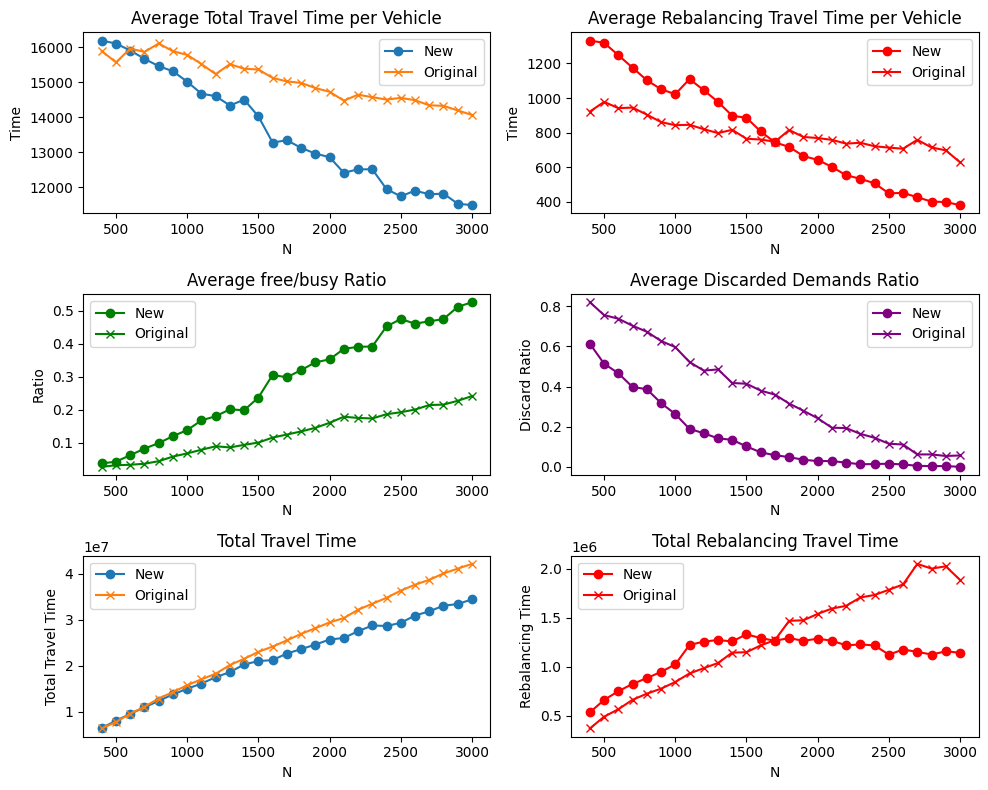

In [1085]:
import matplotlib.pyplot as plt

# x 轴的数据点
x = fleet_size

# 根据存储的数据字典，计算 y 轴的值 (新数据)
y_total_travel_time = [sum(total_travel_time_record[i]) for i in x]
y_total_rebalancing_time = [sum(rebalancing_travel_time_record[i]) for i in x]

# 根据存储的数据字典，计算 y 轴的值 (original数据)
y_total_travel_time_original = [sum(total_travel_time_record_original[i]) for i in x]
y_total_rebalancing_time_original = [sum(rebalancing_travel_time_record_original[i]) for i in x]

# 计算平均值 (新数据)
avg_total_travel_time = [ (sum(total_travel_time_record[i]) / len(total_travel_time_record[i])) for i in x ]
avg_rebalancing_travel_time = [ (sum(rebalancing_travel_time_record[i]) / len(rebalancing_travel_time_record[i])) for i in x ]
avg_ratio = [ (sum(ratio_of_busy_idle_record[i]) / len(ratio_of_busy_idle_record[i])) if len(ratio_of_busy_idle_record[i])>0 else 0 for i in x ]

# 计算平均值 (original数据)
avg_total_travel_time_original = [ (sum(total_travel_time_record_original[i]) / len(total_travel_time_record_original[i])) for i in x ]
avg_rebalancing_travel_time_original = [ (sum(rebalancing_travel_time_record_original[i]) / len(rebalancing_travel_time_record_original[i])) for i in x ]
avg_ratio_original = [ (sum(ratio_of_busy_idle_record_original[i]) / len(ratio_of_busy_idle_record_original[i])) if len(ratio_of_busy_idle_record_original[i])>0 else 0 for i in x ]


# 如果想用占总需求比例来表示平均discard (新数据)
avg_discard = []
for i_val in x:
    total_demands = len(completed_demands_record[i_val]) + len(discarded_demands_record[i_val])
    if total_demands > 0:
        avg_discard.append(len(discarded_demands_record[i_val]) / total_demands)
    else:
        avg_discard.append(0)

# average discard for original 数据
avg_discard_original = []
for i_val in x:
    total_demands_original = len(completed_demands_record_original[i_val]) + len(discarded_demands_record_original[i_val])
    if total_demands_original > 0:
        avg_discard_original.append(len(discarded_demands_record_original[i_val]) / total_demands_original)
    else:
        avg_discard_original.append(0)


fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Average total travel time per vehicle
axes[0,0].plot(x, avg_total_travel_time, marker='o', label='New')
axes[0,0].plot(x, avg_total_travel_time_original, marker='x', label='Original')
axes[0,0].set_title('Average Total Travel Time per Vehicle')
axes[0,0].set_xlabel('N')
axes[0,0].set_ylabel('Time')
axes[0,0].legend()

# Average rebalancing travel time per vehicle
axes[0,1].plot(x, avg_rebalancing_travel_time, marker='o', color='red', label='New')
axes[0,1].plot(x, avg_rebalancing_travel_time_original, marker='x', color='red', label='Original')
axes[0,1].set_title('Average Rebalancing Travel Time per Vehicle')
axes[0,1].set_xlabel('N')
axes[0,1].set_ylabel('Time')
axes[0,1].legend()

# Average ratio of busy/idle
axes[1,0].plot(x, avg_ratio, marker='o', color='green', label='New')
axes[1,0].plot(x, avg_ratio_original, marker='x', color='green', label='Original')
axes[1,0].set_title('Average free/busy Ratio')
axes[1,0].set_xlabel('N')
axes[1,0].set_ylabel('Ratio')
axes[1,0].legend()

# Average discarded demands (as fraction of total demands)
axes[1,1].plot(x, avg_discard, marker='o', color='purple', label='New')
axes[1,1].plot(x, avg_discard_original, marker='x', color='purple', label='Original')
axes[1,1].set_title('Average Discarded Demands Ratio')
axes[1,1].set_xlabel('N')
axes[1,1].set_ylabel('Discard Ratio')
axes[1,1].legend()

# Total travel time
axes[2,0].plot(x, y_total_travel_time, marker='o', label='New')
axes[2,0].plot(x, y_total_travel_time_original, marker='x', label='Original')
axes[2,0].set_title('Total Travel Time')
axes[2,0].set_xlabel('N')
axes[2,0].set_ylabel('Total Travel Time')
axes[2,0].legend()

# Total rebalancing travel time
axes[2,1].plot(x, y_total_rebalancing_time, marker='o', color='red', label='New')
axes[2,1].plot(x, y_total_rebalancing_time_original, marker='x', color='red', label='Original')
axes[2,1].set_title('Total Rebalancing Travel Time')
axes[2,1].set_xlabel('N')
axes[2,1].set_ylabel('Rebalancing Time')
axes[2,1].legend()

plt.tight_layout()
plt.show()
